In [2]:
import keras

from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

Using TensorFlow backend.


[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7183549331572520448, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 1
 }
 incarnation: 2890805343176703500
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:05:00.0"]

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

RANDOM_STATE = 42

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Reshape, Lambda
from keras.layers.convolutional import Conv2D
from keras.utils import np_utils
from keras import backend as K
import pescador

%matplotlib inline
import matplotlib.pyplot as plt

import glob
import keras
import medleydb as mdb
from medleydb import utils
import numpy as np
import os
import pescador
from sklearn.feature_extraction import image

In [5]:
def keras_generator(data_list, input_patch_size,
                    output_patch_size,
                    with_replacement=True,
                    batch_size=32):

    streams = []
    for fpath_in, fpath_out in data_list:
        streams.append(
            pescador.Streamer(
                patch_generator, fpath_in, fpath_out,
                input_patch_size=input_patch_size,
                output_patch_size=output_patch_size,
                batch_size=batch_size
            )
        )

    stream_mux = pescador.Mux(
        streams, 10, with_replacement=with_replacement, lam=500
    )

#     buffered_streamer = pescador.BufferedStreamer(stream_mux, batch_size)

    for batch in stream_mux.tuples('X', 'Y'):
        yield batch


def __grab_patch_output(f, t, n_f, n_t, y_data):
    return y_data[f: f + n_f, t: t + n_t][np.newaxis, :, :]


def __grab_patch_input(f, t, n_f, n_t, n_harms, x_data):
    return np.transpose(
        x_data[:, f: f + n_f, t: t + n_t], (1, 2, 0)
    )[np.newaxis, :, :, :]


def patch_generator(fpath_in, fpath_out, input_patch_size, output_patch_size, batch_size):
    data_in = np.load(fpath_in)#, mmap_mode='r')
    data_out = np.load(fpath_out)#, mmap_mode='r')
    
    n_harms, n_freqs, n_times = data_in.shape
    n_f_in, n_t_in = input_patch_size
    n_f_out, n_t_out = output_patch_size

    f_shift = n_f_in - n_f_out
    t_shift = n_t_in - n_t_out

    while True:
#         f = np.random.randint(0, n_freqs - n_f_in)
        f = 0
        t = np.random.randint(0, n_times - n_t_in)

        x = __grab_patch_input(
            f, t, n_f_in, n_t_in, n_harms, data_in
        )
        y = __grab_patch_output(
            f + f_shift, t + t_shift, n_f_out, n_t_out, data_out
        )
        yield dict(X=x, Y=y)


def get_file_paths(mtrack_list, data_path):
    file_paths = []
    for track_id in mtrack_list:
        input_path = glob.glob(
            os.path.join(data_path, 'inputs', "{}*_input.npy".format(track_id))
        )
        output_path = glob.glob(
            os.path.join(data_path, 'outputs', "{}*_output.npy".format(track_id))
        )
        
        if len(input_path) == 1 and len(output_path) == 1:
            input_path = input_path[0]
            output_path = output_path[0]
            file_paths.append((input_path, output_path))
            
    return file_paths

In [6]:
class Data(object):

    def __init__(self, mtrack_list, data_path, input_patch_size,
                 output_patch_size, batch_size):

        self.mtrack_list = mtrack_list
        self.input_patch_size = input_patch_size
        self.output_patch_size = output_patch_size
        self.batch_size = batch_size

        self.data_path = data_path
        
        (self.train_set,
         self.validation_set,
         self.test_set) = self._train_val_test_split()

        self.train_files = get_file_paths(self.train_set, self.data_path)
        self.validation_files = get_file_paths(
            self.validation_set, self.data_path
        )
        self.test_files = get_file_paths(self.test_set, self.data_path)

    def _train_val_test_split(self):
        full_list = []
        print(len(self.mtrack_list))
        for m in self.mtrack_list:
            globbed = get_file_paths([m], self.data_path)
            if len(globbed) > 0:
                full_list.append(m)

        self.full_list = full_list
        print(len(full_list))
        mtracks = list(mdb.load_multitracks(full_list))
        test_potentials = [
            m.track_id for m in mtracks if m.dataset_version == 'V1'
        ]
        all_others = [
            m.track_id for m in mtracks if m.dataset_version != 'V1'
        ]

        split1 = utils.artist_conditional_split(
            trackid_list=test_potentials, test_size=0.2,
            num_splits=1, random_state=RANDOM_STATE
        )

        test_set = split1[0]['test']
        remaining_tracks = split1[0]['train'] + all_others

        split2 = utils.artist_conditional_split(
            trackid_list=remaining_tracks, test_size=0.15,
            num_splits=1, random_state=RANDOM_STATE
        )

        train_set = split2[0]['train']
        validation_set = split2[0]['test']

        return train_set, validation_set, test_set

    def get_train_generator(self):
        return keras_generator(
            self.train_files,
            input_patch_size=self.input_patch_size,
            output_patch_size=self.output_patch_size,
            batch_size=self.batch_size
        )

    def get_validation_generator(self):
        return keras_generator(
            self.validation_files,
            input_patch_size=self.input_patch_size,
            output_patch_size=self.output_patch_size,
            batch_size=self.batch_size
        )

    def get_test_generator(self):
        return keras_generator(
            self.test_files,
            input_patch_size=self.input_patch_size,
            output_patch_size=self.output_patch_size,
            batch_size=self.batch_size
        )

# load data

In [95]:
data_path = "/scratch/rmb456/multif0_ismir2017/training_data_with_blur/multif0_complete/"
mtrack_list = mdb.TRACK_LIST_V1 + mdb.TRACK_LIST_V2 + mdb.TRACK_LIST_EXTRA
dat = Data(
    mtrack_list, data_path, input_patch_size=(360, 50),
    output_patch_size=(360, 50), batch_size=10
)

320
187


In [96]:
train_generator = dat.get_train_generator()
validation_generator = dat.get_validation_generator()
test_generator = dat.get_test_generator()

# Build Model

In [97]:
 input_shape = (None, None, 6)
inputs = Input(shape=input_shape)

y1 = Conv2D(
    64, (5, 5), padding='same', activation='relu', name='bendy1'
)(inputs)
y2 = Conv2D(
    64, (5, 5), padding='same', activation='relu', name='bendy2'
)(y1)
y3 = Conv2D(
    64, (3, 3), padding='same', activation='relu', name='smoothy1'
)(y2)
y4 = Conv2D(
    64, (3, 3), padding='same', activation='relu', name='smoothy2'
)(y3)
y5 = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='squishy'
)(y4)
predictions = Lambda(lambda x: K.squeeze(x, axis=3))(y5)

model = Model(inputs=inputs, outputs=predictions)

# Compile Model

In [98]:
def bkld(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return K.mean(K.mean(-1.0*y_true* K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1), axis=-1)

def soft_binary_accuracy(y_true, y_pred):
    return K.mean(K.mean(K.equal(K.round(y_true), K.round(y_pred)),  
        axis=-1), axis=-1)

# def soft_binary_accuracy(y_true, y_pred):
#     return K.mean(K.mean(
#         K.prod(
#             K.concatenate(
#                 [(0.98*K.round(y_true) + 0.01), K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32')],
#                 axis=-1
#             ), axis=-1
#         ),
#         axis=-1), axis=-1)

In [99]:
# loss binary cross entropy
model.compile(loss=bkld,
              metrics=['mse', soft_binary_accuracy],
              optimizer='adam')

In [100]:
model.summary(line_length=80)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_7 (InputLayer)                (None, None, None, 6)           0           
________________________________________________________________________________
bendy1 (Conv2D)                     (None, None, None, 64)          9664        
________________________________________________________________________________
bendy2 (Conv2D)                     (None, None, None, 64)          102464      
________________________________________________________________________________
smoothy1 (Conv2D)                   (None, None, None, 64)          36928       
________________________________________________________________________________
smoothy2 (Conv2D)                   (None, None, None, 64)          36928       
________________________________________________________________________________
squishy (Conv2D)            

# Fit Model

In [101]:
samples_per_epoch = 512  # 512 batches, batches size 32
nb_epochs = 100 # up to 100 epochs
nb_val_samples = 1000 # 1000

history = model.fit_generator(
    train_generator, samples_per_epoch, epochs=nb_epochs, verbose=1,
    validation_data=validation_generator, validation_steps=nb_val_samples,
    callbacks=[keras.callbacks.ModelCheckpoint('/scratch/rmb456/multif0_ismir2017/saved_models/model_6.pkl',
                                           save_best_only=True, verbose=1),
               keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
               keras.callbacks.EarlyStopping(patience=15, verbose=0)]
)

Epoch 1/100
512/512 [==============================] - 25s - loss: 0.1313 - mean_squared_error: 0.0071 - soft_binary_accuracy: 0.9888 - val_loss: 0.1270 - val_mean_squared_error: 0.0058 - val_soft_binary_accuracy: 0.9908
Epoch 2/100
512/512 [==============================] - 24s - loss: 0.1268 - mean_squared_error: 0.0058 - soft_binary_accuracy: 0.9908 - val_loss: 0.1244 - val_mean_squared_error: 0.0057 - val_soft_binary_accuracy: 0.9910
Epoch 3/100
512/512 [==============================] - 24s - loss: 0.1293 - mean_squared_error: 0.0059 - soft_binary_accuracy: 0.9907 - val_loss: 0.1221 - val_mean_squared_error: 0.0056 - val_soft_binary_accuracy: 0.9912
Epoch 4/100
512/512 [==============================] - 23s - loss: 0.1330 - mean_squared_error: 0.0061 - soft_binary_accuracy: 0.9904 - val_loss: 0.1248 - val_mean_squared_error: 0.0057 - val_soft_binary_accuracy: 0.9910
Epoch 5/100
512/512 [==============================] - 23s - loss: 0.1344 - mean_squared_error: 0.0062 - soft_binary

In [19]:
# test_eval = model.evaluate_generator(test_generator, 5000, max_q_size=10)

In [79]:
np.argmin(history.history['val_loss'])

36

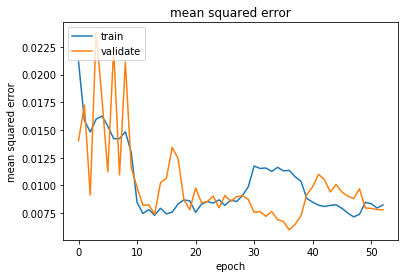

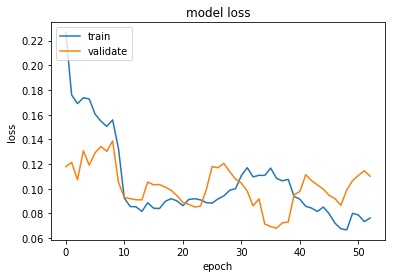

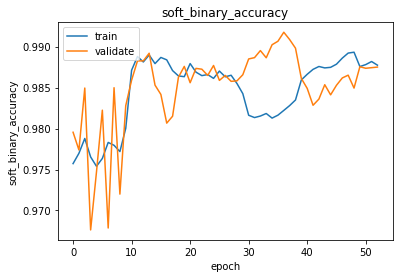

In [80]:
# summarize history for mse
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

# summarize history for soft binary accuracy
plt.plot(history.history['soft_binary_accuracy'])
plt.plot(history.history['val_soft_binary_accuracy'])
plt.title('soft_binary_accuracy')
plt.ylabel('soft_binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [89]:
best_model = Model(inputs=inputs, outputs=predictions)
best_model.load_weights('/scratch/rmb456/multif0_ismir2017/saved_models/model_5.pkl')
best_model.compile(
    loss=bkld,
    metrics=['mse', soft_binary_accuracy],
    optimizer='adam')
# test_eval = best_model.evaluate_generator(test_generator, 5000, max_q_size=10)
# print(test_eval)

('/scratch/rmb456/multif0_ismir2017/training_data_with_blur/multif0_incomplete/inputs/CelestialShore_DieForUs_multif0_incomplete_input.npy', '/scratch/rmb456/multif0_ismir2017/training_data_with_blur/multif0_incomplete/outputs/CelestialShore_DieForUs_multif0_incomplete_output.npy')
0
5000
10000
15000
20000


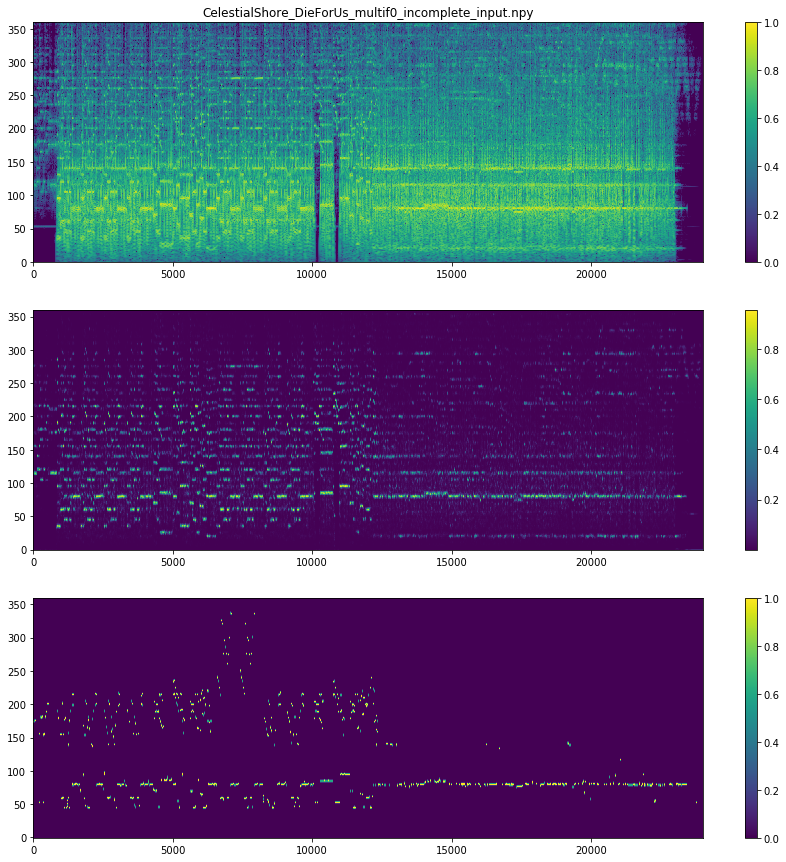

In [86]:
i = np.random.choice(range(len(dat.test_files)))
test_pair = dat.test_files[i]
test_pair = ('/scratch/rmb456/multif0_ismir2017/training_data_with_blur/multif0_incomplete/inputs/CelestialShore_DieForUs_multif0_incomplete_input.npy',
 '/scratch/rmb456/multif0_ismir2017/training_data_with_blur/multif0_incomplete/outputs/CelestialShore_DieForUs_multif0_incomplete_output.npy')
print(test_pair)
if os.path.basename(test_pair[0]).split('_')[1] == "AnEveningWithOliver":
    print("skipping this too big")
else:

    true_output = np.load(test_pair[1])
    input_hcqt = np.load(test_pair[0]).transpose(1, 2, 0)[np.newaxis, :, :, :]

    n_t = input_hcqt.shape[2]
    t_slices = list(np.arange(0, n_t, 5000))
    output_list = []
    for t in t_slices:
        print(t)
        output_list.append(best_model.predict(input_hcqt[:, :, t:t+5000, :])[0, :, :])

    predicted_output = np.hstack(output_list)
    
#     np.save('/home/rmb456/repos/multif0/pred_output_example.npy', predicted_output)
#     np.save('/home/rmb456/repos/multif0/true_output_example.npy', true_output)

    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.title(os.path.basename(test_pair[0]))
    plt.imshow(input_hcqt[0, :, :, 1], origin='lower')
    plt.axis('auto')
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.imshow(predicted_output, origin='lower')
    plt.axis('auto')
    plt.colorbar()

    plt.subplot(3, 1, 3)
    plt.imshow(true_output, origin='lower')
    plt.axis('auto')
    plt.colorbar()

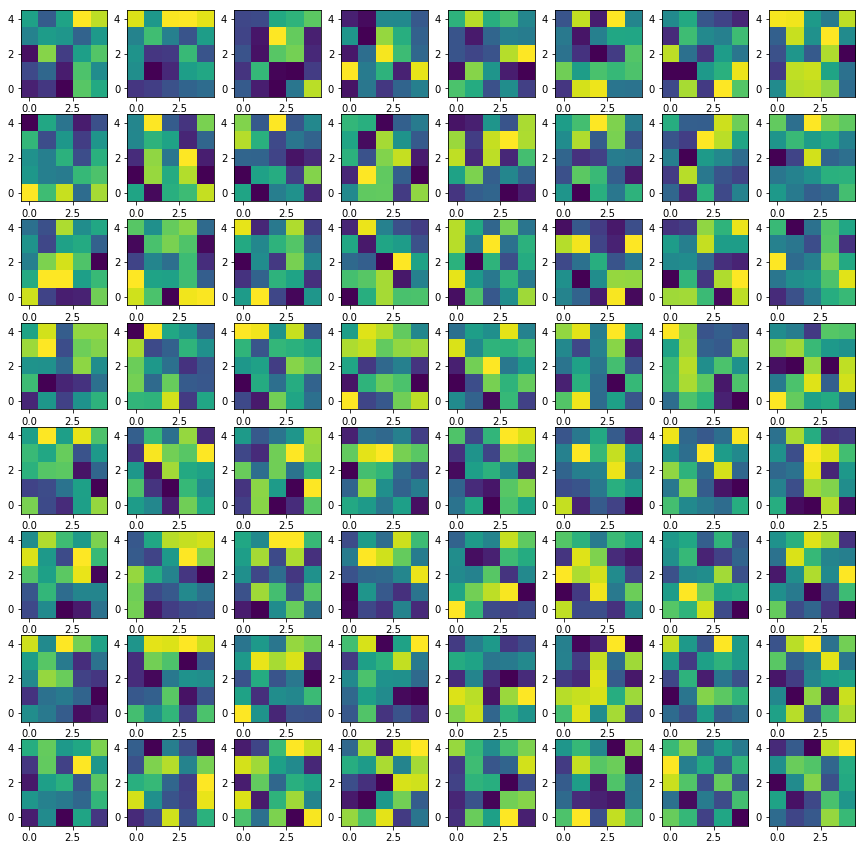

In [94]:
# plot filters
conv_layer = best_model.get_layer(name='bendy2')
weights = conv_layer.get_weights()
weight_array = weights[0]
plt.figure(figsize=(15, 15))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(weight_array[:, :, 0, i], origin='lower')
    plt.axis('square')

plt.show()

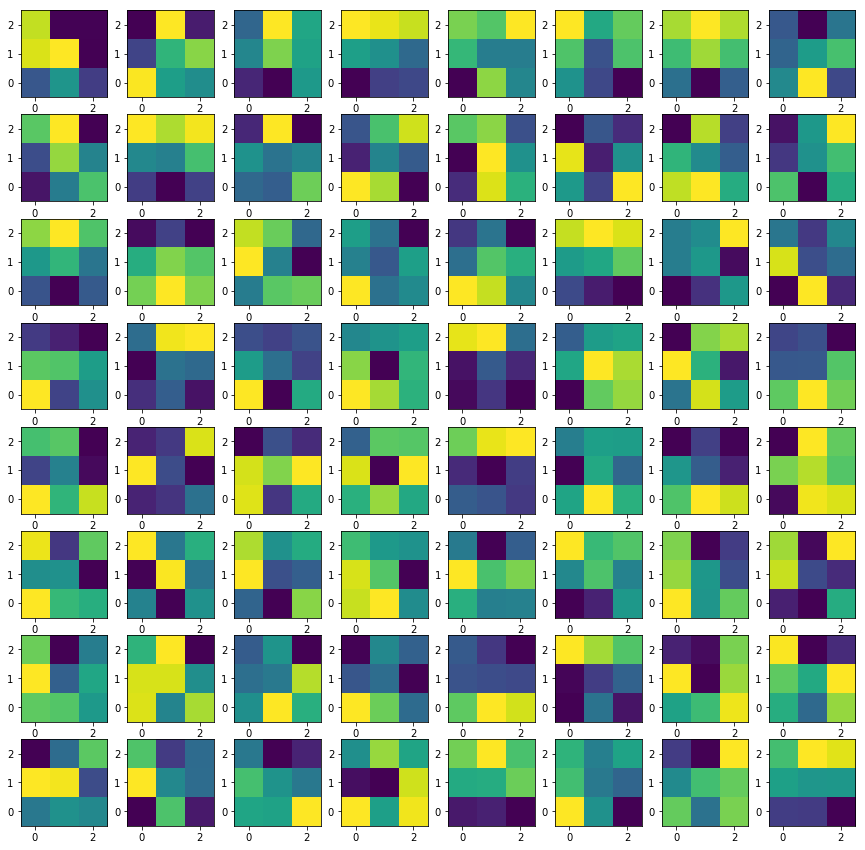

In [95]:
# plot filters
conv_layer = model.get_layer(name='smoothy1')
weights = conv_layer.get_weights()
weight_array = weights[0]
plt.figure(figsize=(15, 15))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(weight_array[:, :, 0, i], origin='lower')
    plt.axis('square')

plt.show()

In [ ]:
def plot_stuff(X, Y, Y_pred):
    sns.set_style('white')
    plt.figure(figsize=(15, 15))
    
    plt.subplot(3, 1, 1)
    plt.title("prediction")
    plt.imshow(Y_pred[0], origin='lower', cmap='hot', vmin=0, vmax=1)
    plt.axis('auto')
#     plt.xlim(a, b)
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.title('target')
    plt.imshow(Y[0], origin='lower', cmap='hot', vmin=0, vmax=1)
    plt.axis('auto')
#     plt.xlim(a, b)
    plt.colorbar()

    plt.subplot(3, 1, 3)
    plt.title('input')
    plt.imshow(X[0, :, :, 0], origin='lower', cmap='hot', vmin=0, vmax=1)
    plt.axis('auto')
#     plt.xlim(a, b)
    plt.colorbar()
    plt.show()

In [ ]:
for X, Y in validation_generator:
    Y_pred = model.predict(X)
    plot_stuff(X, Y, Y_pred)
    break
    if np.sum(Y[0].flatten()) > 0:
        plot_stuff(X, Y, Y_pred)
        break

In [ ]:
for X, Y in train_generator:
    for x, y in zip(X, Y):
        if np.sum(y.flatten()) > 0:
            plt.figure(figsize=(15, 15))
            plt.subplot(2, 1, 1)
            plt.imshow(x[:, :, 0], origin='lower', cmap='hot')
            plt.axis('square')

            plt.subplot(2, 1, 2)
            plt.imshow(y, origin='lower', cmap='hot')
            plt.axis('square')
            break

# Evaluate Model

In [ ]:
model.count_params()

In [ ]:
def get_full_track_prediction(fpath_in, fpath_out, model):
    
    data_in = np.load(fpath_in, mmap_mode='r')
    n_harms, n_freqs, n_times = data_in.shape
    n_f, n_t = (20, 20)

    prediction = np.zeros((n_freqs, n_times))

    cqt_patch_generator = stride_tf(fpath_in, fpath_out, (26, 26), (20, 20))

    for d in cqt_patch_generator:
        f = d['f']
        t = d['t']
        print("{}, {}".format(f, t))
        y_pred = model.predict(d['X']).reshape(n_f, n_t)
        prediction[f: f + n_f, t: t + n_t] = y_pred

    return prediction
    

In [ ]:
fpath_in, fpath_out = dat.test_files[0]
test_prediction = get_full_track_prediction(fpath_in, fpath_out, model)

In [ ]:
fpath_in

In [ ]:
a, b = (0, 25000)
ground_truth = np.load(fpath_out, mmap_mode='r')
input_data = np.load(fpath_in, mmap_mode='r')

plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.imshow(1.0 - test_prediction[:, a:b], origin='lower', cmap='hot')
# plt.imshow((1.0 - test_prediction)**1000, origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(a, b)
# plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(ground_truth[:, a:b], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(a, b)

plt.subplot(3, 1, 3)
plt.imshow(input_data[0, :, a:b], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(a, b)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.imshow(dat3['data_in'][0], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(0, 10000)

In [ ]:
plt.imshow(dat3['data_out'], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(0, 10000)

In [ ]:
import numpy as np

In [ ]:
test = np.zeros((100, 100))

In [ ]:
for i in range(50):
    test[i, i] = 1
for j in range(50, 100):
    test[50, j] = 1

In [ ]:
test

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.imshow(test, origin='lower', interpolation='none')
plt.axis('auto')

In [ ]:
from scipy.ndimage import filters

In [ ]:
test_filt = filters.gaussian_filter1d(test, 2, axis=0, mode='constant')
test_filt = test_filt/np.max(test_filt)

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(test_filt, origin='lower', interpolation='none')
plt.axis('auto')
plt.colorbar()

In [ ]:
rm /scratch/rmb456/multif0_ismir2017/training_data_with_blur/multif0_complete/CelestialShore_DieForUs_multif0_complete.npz